In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import time
import datetime as dt
import random
import psutil
from PIL import Image
import matplotlib.pyplot as plt
from random import shuffle
import glob
import pickle
import torchvision
from torch.optim import lr_scheduler
import torch.nn.functional as F
import math
import time

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

def no_of_params(model):
    sum_ = 0.
    for key, value in model.state_dict().items():
        sum_ += torch.prod(torch.tensor(value.shape))
        #print(value, "----------", torch.prod(torch.tensor(value.shape)))
    return int(sum_)

In [6]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        list_IDs,
    ):
        self.list_IDs  = list_IDs
        self.cache     = {}
        self.input_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/images/"
        self.label_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/labels/"
        
    def __len__(self):
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        ID = self.list_IDs[index]
        if ID in self.cache:
            X = self.cache[ID]['X']
            Y = self.cache[ID]['Y']
        else:
            X = torchvision.io.read_image(
                self.input_dir + str(ID) + ".png "
            ).to(torch.float64)
            X = X[1].unsqueeze(0)/256.
            
            with open(self.label_dir + str(ID), 'rb') as fb:
                Y  = pickle.load(fb)
                
            #Y = [ (i + 3.)/6. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            #Y = [ i/3. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            
            Y = Y[1][0]/3.1415926
            Y = Y - 0.5
            
            Y = torch.tensor( Y, dtype=torch.float64 ).unsqueeze(0)
            
            if psutil.virtual_memory().percent < 50:
                data = {
                    'X' : X,
                    'Y' : Y
                }
                self.cache[ID] = data
        return X,Y
    
all_ids = [str(i) for i in  list(np.arange(0,10000,1))]
train_ids = all_ids[:8000]
val_ids   = all_ids[8000:]#1000]
params = {
    'batch_size'  : 256,
    'shuffle'     : True,
    #'num_workers' : 2
}
training_set         = Dataset(train_ids)
training_generator   = torch.utils.data.DataLoader(
                            training_set,
                            **params,
                            pin_memory=True
                        )
validation_set       = Dataset(val_ids)
validation_generator = torch.utils.data.DataLoader(
                            validation_set,
                            **params,
                            pin_memory=True
                        )

tensor([-0.3295], dtype=torch.float64)

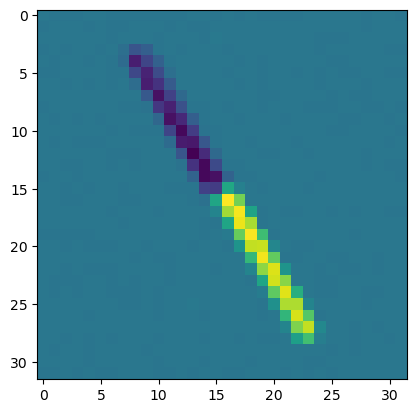

In [7]:
for batch in training_generator:
    break
batch[1].shape
plt.imshow(batch[0][7][0])
batch[1][7]

In [8]:
def train_one_epoch(
    model,
    optimizer
):
    running_loss = 0.
    #loss_fn = nn.MSELoss()
    loss_fn = nn.L1Loss()
    
    model.train(True)
    
    for i,batch in enumerate(training_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

def validate_one_epoch(
    model,
    optimizer
):
    running_loss = 0.
    #loss_fn = nn.MSELoss()
    loss_fn = nn.L1Loss()
    model.train(False)
    model.eval()
    
    for i,batch in enumerate(validation_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        #optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

In [15]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1  = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=1)
        self.bn1    = nn.BatchNorm2d(8)
        self.conv2  = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=1)
        self.bn2    = nn.BatchNorm2d(16)
        self.pool   = nn.MaxPool2d(2,2)
        self.conv4  = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=1)
        self.bn4    = nn.BatchNorm2d(32)
        self.conv5  = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.bn5    = nn.BatchNorm2d(64)
        self.fc1    = nn.Linear(64*10*10, 1)

    def forward(self, input):
        output = torch.tanh(self.bn1(self.conv1(input)))      
        output = torch.tanh(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = torch.tanh(self.bn4(self.conv4(output)))     
        output = torch.tanh(self.bn5(self.conv5(output))) 
        #print(output.shape)
        output = output.view(-1, 64*10*10)
        output = self.fc1(output)
        output = torch.tanh(output)

        return output

In [16]:
model = Network()
no_of_params(model)
#model(torch.randn(32,1,32,32))

74405

EPOCH:  1  Train loss:  0.1575  Val loss:  0.1725  LR:  1.6e-06
EPOCH:  2  Train loss:  0.1081  Val loss:  0.0883  LR:  1.28e-06
EPOCH:  3  Train loss:  0.0966  Val loss:  0.0865  LR:  1.024e-06
EPOCH:  4  Train loss:  0.0855  Val loss:  0.0906  LR:  8.192e-07
EPOCH:  5  Train loss:  0.1015  Val loss:  0.0985  LR:  6.554e-07
EPOCH:  6  Train loss:  0.0926  Val loss:  0.0844  LR:  5.243e-07
EPOCH:  7  Train loss:  0.0847  Val loss:  0.0868  LR:  4.194e-07
EPOCH:  8  Train loss:  0.088  Val loss:  0.0912  LR:  3.355e-07
EPOCH:  9  Train loss:  0.086  Val loss:  0.0802  LR:  2.684e-07
EPOCH:  10  Train loss:  0.0733  Val loss:  0.0687  LR:  2.147e-07
EPOCH:  11  Train loss:  0.0666  Val loss:  0.0655  LR:  1.718e-07
EPOCH:  12  Train loss:  0.065  Val loss:  0.0659  LR:  1.374e-07
EPOCH:  13  Train loss:  0.0647  Val loss:  0.0649  LR:  1.1e-07
EPOCH:  14  Train loss:  0.0633  Val loss:  0.0628  LR:  8.8e-08
EPOCH:  15  Train loss:  0.0602  Val loss:  0.0593  LR:  7.04e-08
EPOCH:  16  Tra

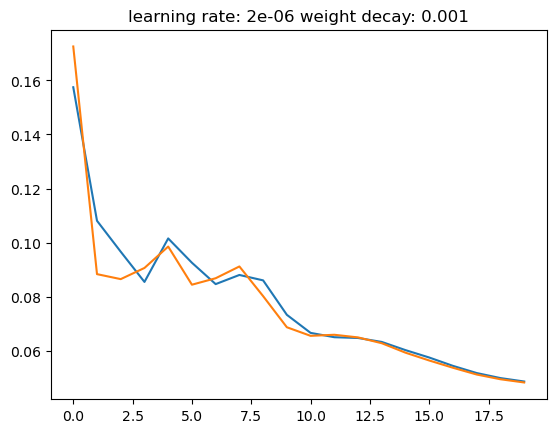

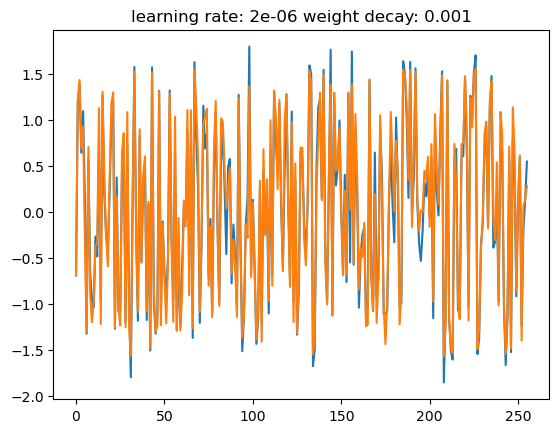

In [18]:
lr = 2e-6
wd = 1e-3
model = Network()

epochs = 20
optimizer = torch.optim.Adam(
        model.parameters(),
        lr           = lr,
        weight_decay = wd
    )

gamma = 0.8#0.85
# scheduler_step_size = 1
# scheduler = lr_scheduler.StepLR(
#     optimizer,
#     step_size = scheduler_step_size, 
#     gamma     = gamma)

scheduler = lr_scheduler.ExponentialLR(
    optimizer, 
    #step_size = scheduler_step_size, 
    gamma     = gamma)

train_losses = []
val_losses   = []
lrs          = []
for epoch in range(epochs):
    train_loss = train_one_epoch(model,optimizer)
    val_loss   = validate_one_epoch(model,optimizer)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    lrs.append(scheduler.optimizer.param_groups[0]['lr'])
    scheduler.step()
    print("EPOCH: ",epoch + 1, " Train loss: ", round(train_loss,4), " Val loss: ",round(val_loss,4), " LR: ",round(scheduler.optimizer.param_groups[0]['lr'],10))

txt = "learning rate: " + str(lr) +  " weight decay: " + str(wd)
plt.title(txt)
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

for batch in validation_generator:
    break
output = model(batch[0])
output
plt.title(txt)
plt.plot(output.detach().numpy()*3.1415926)
plt.plot(batch[1].detach().numpy()*3.1415926)
plt.show()